[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Winfredy/SadTalker/blob/main/quick_demo.ipynb)

Installation (around 5 mins)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [38]:
!pip install pytube
!pip install pythumb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 3.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from pytube import YouTube
import os

In [4]:
pwd

'/content'

In [5]:
%cd /content/drive/MyDrive/VoiceClone/Experiment_Audio

/content/drive/MyDrive/VoiceClone/Experiment_Audio


In [6]:
pwd

'/content/drive/MyDrive/VoiceClone/Experiment_Audio'

In [ ]:
# READ THIS LINK

################       https://www.alphr.com/how-to-get-transcript-youtube-video/

In [80]:
# DOWNLOAD AUDIO FROM YOUTUBE WITH BELOW CODE
##https://www.youtube.com/watch?v=zpOK4wjC4h4


yt = YouTube(str("https://www.youtube.com/watch?v=rkZzg7Vowao"))

video = yt.streams.filter(only_audio = True).first()
destination = '.'
out_file = video.download(output_path = destination)
base, ext = os.path.splitext(out_file)
new_file = base + '.mp3'
os.rename(out_file, new_file)

In [39]:
# GENERATE THUMBNAIL FROM YOUTUBE VIDEO
from pythumb import Thumbnail


In [40]:
t = Thumbnail('https://youtu.be/rkZzg7Vowao')
t.fetch()
t.save('.')
# ./aqz-KE-bpKQ.jpg

'/content/drive/MyDrive/VoiceClone/Experiment_Audio/rkZzg7Vowao.jpg'

In [ ]:
# REDUCE AUDIO NOISE FROM BELOW CODE

In [107]:
import time
from datetime import timedelta as td


def _stft(y, n_fft, hop_length, win_length):
    return librosa.stft(y=y, n_fft=n_fft, hop_length=hop_length, win_length=win_length)


def _istft(y, hop_length, win_length):
    #return librosa.istft(y, hop_length, win_length)
    return librosa.istft(y)


def _amp_to_db(x):
    return librosa.core.amplitude_to_db(x, ref=1.0, amin=1e-20, top_db=80.0)


def _db_to_amp(x,):
    return librosa.core.db_to_amplitude(x, ref=1.0)


def plot_spectrogram(signal, title):
    fig, ax = plt.subplots(figsize=(20, 4))
    cax = ax.matshow(
        signal,
        origin="lower",
        aspect="auto",
        cmap=plt.cm.seismic,
        vmin=-1 * np.max(np.abs(signal)),
        vmax=np.max(np.abs(signal)),
    )
    fig.colorbar(cax)
    ax.set_title(title)
    plt.tight_layout()
    plt.show()


def plot_statistics_and_filter(
    mean_freq_noise, std_freq_noise, noise_thresh, smoothing_filter
):
    fig, ax = plt.subplots(ncols=2, figsize=(20, 4))
    plt_mean, = ax[0].plot(mean_freq_noise, label="Mean power of noise")
    plt_std, = ax[0].plot(std_freq_noise, label="Std. power of noise")
    plt_std, = ax[0].plot(noise_thresh, label="Noise threshold (by frequency)")
    ax[0].set_title("Threshold for mask")
    ax[0].legend()
    cax = ax[1].matshow(smoothing_filter, origin="lower")
    fig.colorbar(cax)
    ax[1].set_title("Filter for smoothing Mask")
    plt.show()


def removeNoise(
    audio_clip,
    noise_clip,
    n_grad_freq=2,
    n_grad_time=4,
    n_fft=2048,
    win_length=2048,
    hop_length=512,
    n_std_thresh=1.5,
    prop_decrease=1.0,
    verbose=False,
    visual=False,
):
    """Remove noise from audio based upon a clip containing only noise

    Args:
        audio_clip (array): The first parameter.
        noise_clip (array): The second parameter.
        n_grad_freq (int): how many frequency channels to smooth over with the mask.
        n_grad_time (int): how many time channels to smooth over with the mask.
        n_fft (int): number audio of frames between STFT columns.
        win_length (int): Each frame of audio is windowed by `window()`. The window will be of length `win_length` and then padded with zeros to match `n_fft`..
        hop_length (int):number audio of frames between STFT columns.
        n_std_thresh (int): how many standard deviations louder than the mean dB of the noise (at each frequency level) to be considered signal
        prop_decrease (float): To what extent should you decrease noise (1 = all, 0 = none)
        visual (bool): Whether to plot the steps of the algorithm

    Returns:
        array: The recovered signal with noise subtracted

    """
    if verbose:
        start = time.time()
    # STFT over noise
    noise_stft = _stft(noise_clip, n_fft, hop_length, win_length)
    noise_stft_db = _amp_to_db(np.abs(noise_stft))  # convert to dB
    # Calculate statistics over noise
    mean_freq_noise = np.mean(noise_stft_db, axis=1)
    std_freq_noise = np.std(noise_stft_db, axis=1)
    noise_thresh = mean_freq_noise + std_freq_noise * n_std_thresh
    if verbose:
        print("STFT on noise:", td(seconds=time.time() - start))
        start = time.time()
    # STFT over signal
    if verbose:
        start = time.time()
    sig_stft = _stft(audio_clip, n_fft, hop_length, win_length)
    sig_stft_db = _amp_to_db(np.abs(sig_stft))
    if verbose:
        print("STFT on signal:", td(seconds=time.time() - start))
        start = time.time()
    # Calculate value to mask dB to
    mask_gain_dB = np.min(_amp_to_db(np.abs(sig_stft)))
    print(noise_thresh, mask_gain_dB)
    # Create a smoothing filter for the mask in time and frequency
    smoothing_filter = np.outer(
        np.concatenate(
            [
                np.linspace(0, 1, n_grad_freq + 1, endpoint=False),
                np.linspace(1, 0, n_grad_freq + 2),
            ]
        )[1:-1],
        np.concatenate(
            [
                np.linspace(0, 1, n_grad_time + 1, endpoint=False),
                np.linspace(1, 0, n_grad_time + 2),
            ]
        )[1:-1],
    )
    smoothing_filter = smoothing_filter / np.sum(smoothing_filter)
    # calculate the threshold for each frequency/time bin
    db_thresh = np.repeat(
        np.reshape(noise_thresh, [1, len(mean_freq_noise)]),
        np.shape(sig_stft_db)[1],
        axis=0,
    ).T
    # mask if the signal is above the threshold
    sig_mask = sig_stft_db < db_thresh
    if verbose:
        print("Masking:", td(seconds=time.time() - start))
        start = time.time()
    # convolve the mask with a smoothing filter
    sig_mask = scipy.signal.fftconvolve(sig_mask, smoothing_filter, mode="same")
    sig_mask = sig_mask * prop_decrease
    if verbose:
        print("Mask convolution:", td(seconds=time.time() - start))
        start = time.time()
    # mask the signal
    sig_stft_db_masked = (
        sig_stft_db * (1 - sig_mask)
        + np.ones(np.shape(mask_gain_dB)) * mask_gain_dB * sig_mask
    )  # mask real
    sig_imag_masked = np.imag(sig_stft) * (1 - sig_mask)
    sig_stft_amp = (_db_to_amp(sig_stft_db_masked) * np.sign(sig_stft)) + (
        1j * sig_imag_masked
    )
    if verbose:
        print("Mask application:", td(seconds=time.time() - start))
        start = time.time()
    # recover the signal
    recovered_signal = _istft(sig_stft_amp, hop_length, win_length)
    recovered_spec = _amp_to_db(
        np.abs(_stft(recovered_signal, n_fft, hop_length, win_length))
    )
    if verbose:
        print("Signal recovery:", td(seconds=time.time() - start))
    if visual:
        plot_spectrogram(noise_stft_db, title="Noise")
    if visual:
        plot_statistics_and_filter(
            mean_freq_noise, std_freq_noise, noise_thresh, smoothing_filter
        )
    if visual:
        plot_spectrogram(sig_stft_db, title="Signal")
    if visual:
        plot_spectrogram(sig_mask, title="Mask applied")
    if visual:
        plot_spectrogram(sig_stft_db_masked, title="Masked signal")
    if visual:
        plot_spectrogram(recovered_spec, title="Recovered spectrogram")
    return recovered_signal

In [7]:
import librosa
import librosa.display
import pandas as pd
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
from pathlib import Path
from pylab import rcParams
rcParams['figure.figsize'] = 14, 6
import IPython
import csv
# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
#Reports
from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

In [110]:
Path = "/content/drive/MyDrive/VoiceClone/Experiment_Audio/" + "AUDIO_Scientist_MAIN.mp3"


In [111]:
y, sr = librosa.load(Path)

In [112]:
y

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [113]:
sr

22050

In [7]:

IPython.display.Audio(data=y, rate=sr)

NameError: ignored

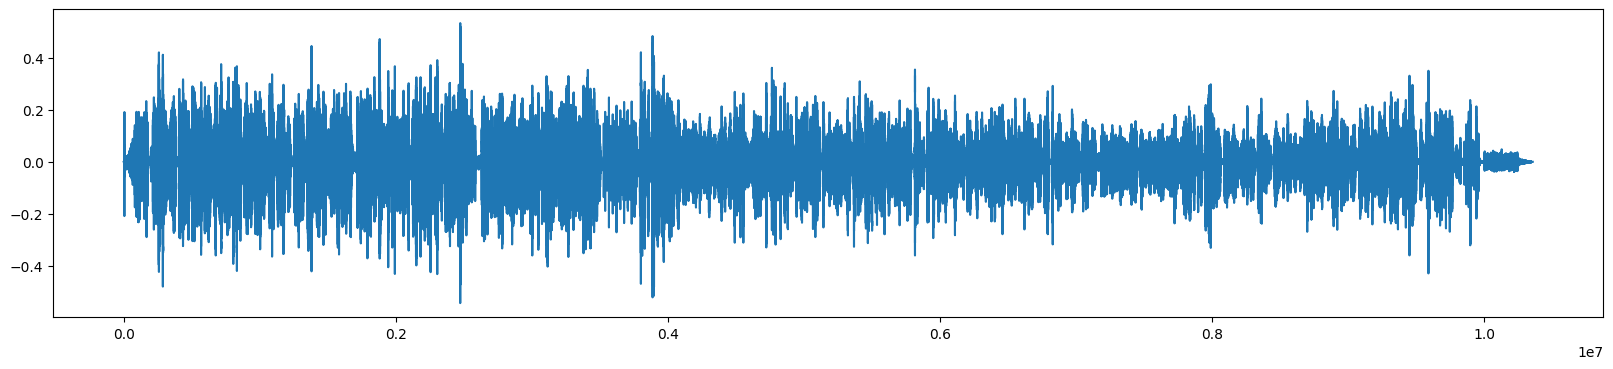

In [67]:
fig, ax = plt.subplots(figsize=(20,4))
ax.plot(y)

In [72]:
output = removeNoise(audio_clip=y, noise_clip=y,verbose=True,visual=True)

Output hidden; open in https://colab.research.google.com to view.

In [75]:
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,4))
plt.plot(output, color='black')
ax.set_xlim((0, len(output)))
plt.show()
# play back a sample of the song
IPython.display.Audio(data=output, rate=sr)

Output hidden; open in https://colab.research.google.com to view.

In [27]:
Path = "/content/drive/MyDrive/VoiceClone/Experiment_Audio/" + "Scientist_ENGLISH_VOICE"
sr = 16000

In [28]:
y1,sr = librosa.load(Path, sr=sr)

In [29]:
from IPython.display import Audio, IFrame, display

display(Audio(y1,rate=sr))

Output hidden; open in https://colab.research.google.com to view.

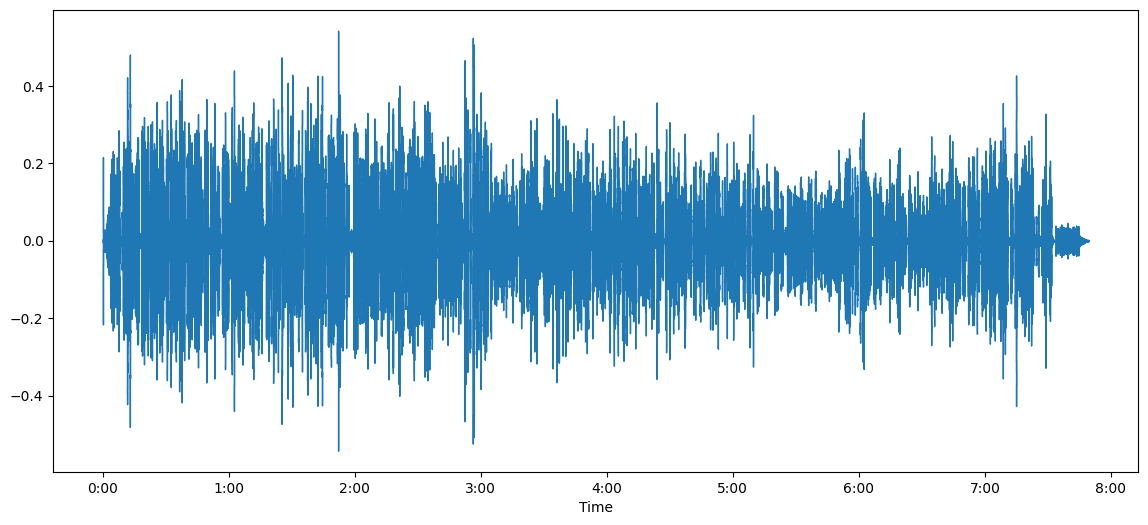

In [37]:
librosa.display.waveshow(y1,sr=sr, x_axis='time');

In [33]:
S1 = librosa.feature.melspectrogram(y=y1, sr=sr, n_mels=128)
D1 = librosa.power_to_db(S1, ref=np.max)
#librosa.display.specshow(D1, x_axis='time', y_axis='mel');

In [34]:
from scipy import signal
import random


def f_high(y,sr):
    b,a = signal.butter(10, 2000/(sr/2), btype='highpass')
    yf = signal.lfilter(b,a,y)
    return yf

In [35]:
yf1 = f_high(y1, sr)

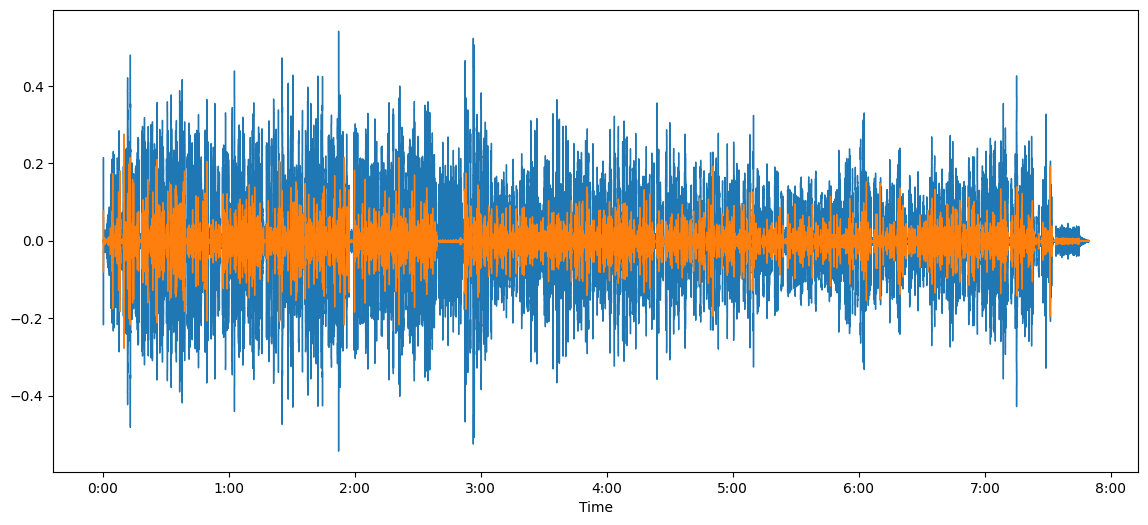

In [36]:
librosa.display.waveshow(y1,sr=sr, x_axis='time');
librosa.display.waveshow(yf1,sr=sr, x_axis='time');

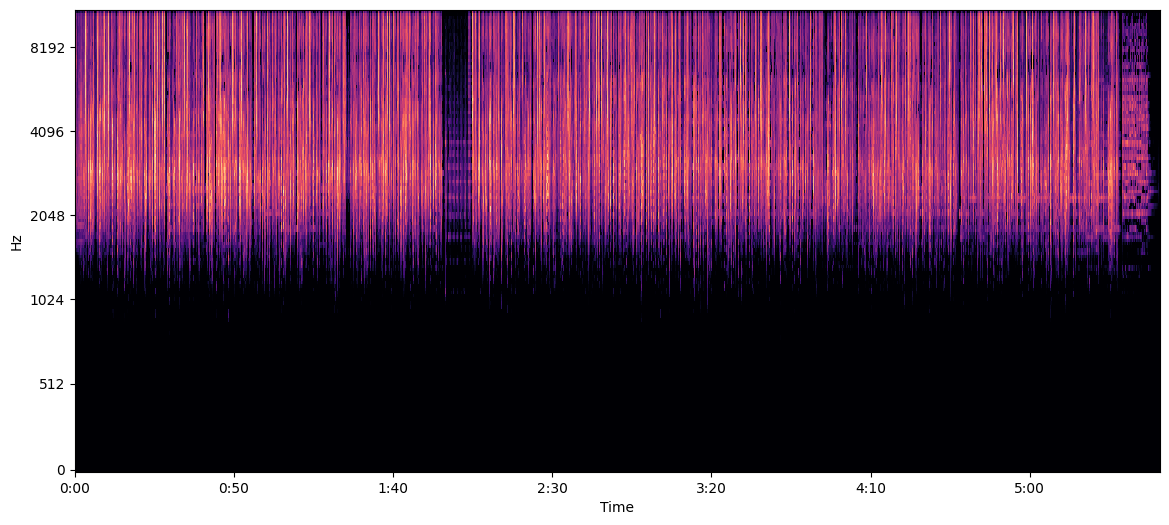

In [38]:
Sf1 = librosa.feature.melspectrogram(y=yf1, sr=sr, n_mels=128)
Df1 = librosa.power_to_db(Sf1, ref=np.max)
librosa.display.specshow(Df1, x_axis='time', y_axis='mel');

In [39]:
display(Audio(yf1,rate=sr))

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
Path = "/content/drive/MyDrive/VoiceClone/Experiment_Audio/"
rate, data = wavfile.read(Path+"AUDIO_Scientist_MAIN.mp3")
# perform noise reduction
reduced_noise = nr.reduce_noise(y=data, sr=rate)
wavfile.write("REDUCED_AUDIO_Scientist_MAIN.mp3", rate, reduced_noise)

ValueError: ignored